In [15]:
import numpy as np
import pandas as pd
import scipy.optimize as opt
import sympy as sp
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
data = pd.read_csv('SL_data.csv')
data

,w (rad/s),w_err (rad/s),L1 (cm),L1_err (cm),L2 (cm),L2_err (cm),MR (cm),MR_err (cm),MR_MFL (cm),MR_MFL_err (cm),MFL_MF (cm),MFL_MF_err (cm),s (um),s_err (um),scope (cm),scope_err (cm)
0,0,0,92.95,0.05,61.35,0.05,17.1,0.05,449,5,374,5,955,4,81.9,0.05
1,-750,1,92.95,0.05,61.35,0.05,17.1,0.05,449,5,374,5,942,4,81.9,0.05
2,-1500,1,92.95,0.05,61.35,0.05,17.1,0.05,449,5,374,5,930,4,81.9,0.05
3,750,1,92.95,0.05,61.35,0.05,17.1,0.05,449,5,374,5,969,4,81.9,0.05
4,1500,1,92.95,0.05,61.35,0.05,17.1,0.05,449,5,374,5,982,4,81.9,0.05


In [43]:
#Define relevant quantities
#Notes: s/s_err actually in units of 10 micrometers
#       w/w_err actually in units of revolutions/second

w = data['w (rad/s)']*(2*np.pi) #rad/s
w_err = data['w_err (rad/s)']*(2*np.pi)
s = data['s (um)'] * 10**-5 #meters
s_err = (data['s_err (um)']-4+2.5)* 10**-5 #meters

L1_fl = 48 * 10**-3 #focal lenght of lense 1
L2_fl = 252 * 10**-3 #focal length of lense 2
A = (data['L1 (cm)'][0] - data['L2 (cm)'][0])*0.01 - L1_fl
B = (data['L2 (cm)'][0] - data['MR (cm)'][0])*0.01
D = (data['MR_MFL (cm)'][0] + data['MFL_MF (cm)'][0])*0.01
A_err = (data['L1_err (cm)'][0] + data['L2_err (cm)'][0])*0.01
B_err = (data['L2_err (cm)'][0] + data['MR_err (cm)'][0])*0.01
D_err = (data['MR_MFL_err (cm)'][0] + data['MFL_MF_err (cm)'][0])*0.01
print('A = {} m'.format(A))
print('B = {} m'.format(B))
print('D = {} m'.format(D))
print(A_err,B_err,D_err)

A = 0.268 m
B = 0.4425 m
D = 8.23 m
0.001 0.001 0.1


Text(0, 0.5, 'Spot position (mm)')

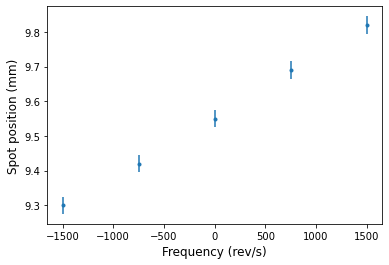

In [44]:
plt.errorbar(w/(2*np.pi),s*10**3,xerr=w_err/(2*np.pi),yerr=s_err*10**3,fmt='.')
plt.xlabel('Frequency (rev/s)',size=12)
plt.ylabel('Spot position (mm)',size=12)

In [45]:
#Define the W matrix elements
W_11 = sum([(w[i]/s_err[i])**2 for i in range(len(w))])
W_12 = sum([w[i]/s_err[i]**2 for i in range(len(w))])
W_21 = W_12
W_22 = sum([1/s_err[i]**2 for i in range(len(w))])

print('W11 = {}'.format(W_11))
print('W12 = {}'.format(W_12))
print('W21 = {}'.format(W_21))
print('W22 = {}'.format(W_22))

W11 = 3.553057584392169e+17
W12 = 0.001953125
W21 = 0.001953125
W22 = 8000000000.0


In [69]:
#Define the W^-1 matrix (which is what we actually care about)
det = W_11*W_22 - W_21*W_12 #determinant
W11 = 1/det * W_22
W12 = 1/det * -W_21
W21 = 1/det * -W_12
W22 = 1/det * W_11

print('W^-1_11 = {}'.format(W11))
print('W^-1_12 = {}'.format(W12))
print('W^-1_21 = {}'.format(W21))
print('W^-1_22 = {}'.format(W22))

W^-1_11 = 2.8144773233982716e-18
W^-1_12 = -6.871282527827812e-31
W^-1_21 = -6.871282527827812e-31
W^-1_22 = 1.25e-10


In [70]:
#Want to fit data w/ linear model (y=mx+b)
#Now compute the best-fit values of m, b
#See Statistics and Liklihood handout for these formulas

m = W11 * sum([s[i]*w[i]/s_err[i]**2 for i in range(len(w))]) + W12 * sum([s[i]/s_err[i]**2 for i in range(len(w))])
b = W21 * sum([s[i]*w[i]/s_err[i]**2 for i in range(len(w))]) + W22 * sum([s[i]/s_err[i]**2 for i in range(len(w))])
m_err = np.sqrt(W11)
b_err = np.sqrt(W22)

print('m = {} +/- {}'.format(m,m_err))
print('b = {} +/- {}'.format (b,b_err))

m = 2.7799063393384196e-08 +/- 1.6776404034829012e-09
b = 0.009556 +/- 1.1180339887498949e-05


In [57]:
#Let's try an automatic curve fit to check

def line_model(x,m,b):
    y = m*x + b
    return y

fit, dfit = opt.curve_fit(line_model,w,s,sigma=s_err,p0=[0,1],absolute_sigma=True)
m_auto=fit[0]; m_auto_err=np.sqrt(dfit[0,0])
b_auto=fit[1]; b_auto_err=np.sqrt(dfit[1,1])
print('m auto = {} +/- {}'.format(m_auto,m_auto_err))
print('b auto = {} +/- {}'.format (b_auto,b_auto_err))

m auto = 2.779906331795204e-08 +/- 1.6776404505268933e-09
b auto = 0.009556 +/- 1.1180339879704496e-05


Text(0, 0.5, 'Spot position (mm)')

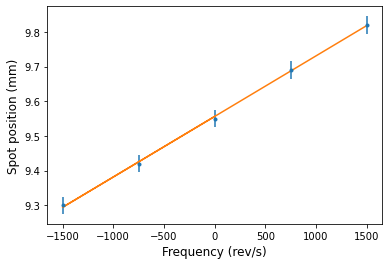

In [64]:
plt.errorbar(w/(2*np.pi),s*10**3,xerr=w_err/(2*np.pi),yerr=s_err*10**3,fmt='.')
plt.plot(w/(2*np.pi),line_model(w/(2*np.pi),m*(2*np.pi),b)*10**3) #I've converted all quantities so that plots are in rev/s, mm
plt.xlabel('Frequency (rev/s)',size=12)
plt.ylabel('Spot position (mm)',size=12)

In [65]:
#Derive c from slope: c = (1/m)*4AD^2/(D+B) - see SL manual + my lab notes for calculation
C = 4*A*(D**2)/(D+B)/m
print("c = {} x 10^8 m/s".format(C/10**8))

c = 3.011757381056682 x 10^8 m/s


In [66]:
#Error propagation
from sympy.abc import a,b,c,d,r #r=slope
sublist = [(a,A),(b,B),(d,D),(r,m)]
c = 4*a*(d**2)/(d+b)/r
dcda = c.diff(a)
dcdb = c.diff(b)
dcdd = c.diff(d)
dcdr = c.diff(r)

c_var = (A_err**2 * dcda**2) + (B_err**2 * dcdb**2) + (D_err**2 * dcdd**2) + (m_err**2 * dcdr**2)
c_err = c_var**0.5
C_err = c_err.subs(sublist)
print("c err = {} x 10^8 m/s".format(C_err/10**8))

c err = 0.186120862036007 x 10^8 m/s


In [67]:
print("Speed of light = (%.1f +/- %.1f) x 10^8 m/s" %(C/10**8,C_err/10**8))

Speed of light = (3.0 +/- 0.2) x 10^8 m/s


In [71]:
#Calculate X^2 test statistic
X2 = 0
for x_i, y_i, dy_i in zip(w,s,s_err):
    X2 = X2 + (y_i - m*x_i - b)**2/(dy_i)**2
print(X2)

0.17599999999998567
